In [1]:
import json
import pandas as pd
import numpy as np

Sensor_readings = pd.read_json('data/json/W512.w512_readings (1).json')
Aircon_Data = pd.read_json('data/json/W512.w512_aircon_status (1).json')
Weather_readings = pd.read_json('data/json/user.weather_data (1).json')

def convert_AirconData(data):
    records = []
    
    for index, row in data.iterrows():
        # Parse FC_FullStatus_Readings if it's a string representation of a dictionary
        if isinstance(row['FC_FullStatus_Readings'], str):
            fc_readings = ast.literal_eval(row['FC_FullStatus_Readings'])
        else:
            fc_readings = row['FC_FullStatus_Readings']


        try:
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))

        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            combined_datetime = None
            formatted_datetime = None

        
        # Create a record with base information
        record = {
            'Datetime': formatted_datetime
        }
        
        # Add each FC Unit's details as separate columns
        for unit, unit_data in fc_readings.items():
            record[f'{unit}_Status'] = unit_data['Status']
            record[f'{unit}_Fan_Status'] = unit_data['Fan_Status']
            record[f'{unit}_Set_Point'] = unit_data['Set_Point']
            record[f'{unit}_Operation_Mode'] = unit_data['Operation_Mode']
        
        records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(records)
    return df


def convert_sensorReadings(data):
    records = []
    
    # List of keys to exclude from Lorawan_Readings
    include_keys_1 = ["24E124725E285123", "24E124725E331695","24E124725E331744",
                      "24E124725E332483","24E124725E290348","24E124725E331733","24E124725E286745"]#"24E124136D316361" is suppiosed to be outdoor but it is not outdoor yet
    include_keys_2 = ["Sensor_1","Sensor_3","Sensor_6"]
    
    for index, row in data.iterrows():
        # Parse Energy_Readings if it's a string representation of a dictionary
        if isinstance(row['Energy_Readings'], str):
            Energy_readings = ast.literal_eval(row['Energy_Readings'])
        else:
            Energy_readings = row['Energy_Readings']
            
        # Parse Lorawan_Readings if it's a string representation of a dictionary
        if isinstance(row['Lorawan_Readings'], str):
            Lorawan_Readings = ast.literal_eval(row['Lorawan_Readings'])
        else:
            Lorawan_Readings = row['Lorawan_Readings']

        try:
            # Combine the date and time columns to create a datetime object
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))
        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            formatted_datetime = None

        # Create a record with base information
        record = {
            'Datetime': formatted_datetime
        }
        
        # Add each Energy sensor's details as separate columns
        for unit, unit_data in Energy_readings.items():
            if unit not in include_keys_2:
                continue
                
            record[f'{unit}_Current'] = unit_data['Current']
            record[f'{unit}_Energy'] = unit_data['Energy']
            record[f'{unit}_Power'] = unit_data['Power']
        
        # Add each Lorawan device's details as separate columns
        for unit, unit_data in Lorawan_Readings.items():
            if unit not in include_keys_1:
                continue
            record[f'{unit}_Humidity'] = unit_data.get('humidity', None)
            record[f'{unit}_Temperature'] = unit_data.get('temperature', None)

            co2_value = unit_data.get('co2', None)
            if co2_value is not None:
                record[f'{unit}_CO2'] = co2_value

        # Append the record to the list of records
        records.append(record)
    df=pd.DataFrame(records)
    return df


def convert_weatherData(data):
    records = []
    for index, row in data.iterrows():
        # Parse Energy_Readings if it's a string representation of a dictionary
        if isinstance(row['result'], str):
            weather_results = ast.literal_eval(row['result'])
        else:
            weather_results = row['result']
            
        try:
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))
        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            formatted_datetime = None

        record = {
            'Datetime': formatted_datetime
        }  

        record['weather_status'] = weather_results['weather_status']
        record['weather_temp'] = weather_results['weather_temp']
        record['weather_humid'] = weather_results['weather_humidity']
            
        records.append(record)
    df=pd.DataFrame(records)
    return df



Aircon_data_df = convert_AirconData(Aircon_Data)
Aircon_data_df = Aircon_data_df[3194:]
Sensor_readings_df = convert_sensorReadings(Sensor_readings)
Sensor_readings_df = Sensor_readings_df.interpolate(method='linear')
weather_readings_df = convert_weatherData(Weather_readings)

# Merge Aircon data with Sensor readings using merge_asof
merged_df = pd.merge_asof(Aircon_data_df, Sensor_readings_df, on='Datetime', direction='nearest')

# Now, merge the Weather readings with the previous result using merge_asof
merged_df = pd.merge_asof(merged_df, weather_readings_df, on='Datetime', direction='nearest')


merged_df['total_energy'] = (
    merged_df['Sensor_1_Energy'] +
    merged_df['Sensor_3_Energy'] +
    merged_df['Sensor_6_Energy']
)

merged_df['total_power'] = (
    merged_df['Sensor_1_Power'] +
    merged_df['Sensor_3_Power'] +
    merged_df['Sensor_6_Power']
)

merged_df['total_current'] = (
    merged_df['Sensor_1_Current'] +
    merged_df['Sensor_3_Current'] +
    merged_df['Sensor_6_Current']
)

temperature_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "temperature" in col.lower()
]
humidity_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "humidity" in col.lower()
]
co2_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "co2" in col.lower()
]

merged_df['avg_temperature'] = merged_df[temperature_col].mean(axis=1)
merged_df['avg_humidity'] = merged_df[humidity_col].mean(axis=1)
merged_df['avg_co2'] = merged_df[co2_col].mean(axis=1)

merged_df['hour'] = pd.to_datetime(merged_df['Datetime']).dt.hour
merged_df['Day_of_week'] = pd.to_datetime(merged_df['Datetime']).dt.dayofweek
print("successful")



successful


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Input and categorical features
input_features = [
    'avg_temperature', 'avg_humidity', 'avg_co2',
    'weather_temp', 'weather_humid', 'total_energy',
    'total_power', 'total_current', 'hour', 'Day_of_week'
]
cat_features = ['weather_status']

# Fan unit columns
fan_unit_col = [col for col in merged_df.columns if "fc_unit" in col.lower()]

# Split X and y
X = merged_df[input_features + cat_features]
y = merged_df[fan_unit_col]

# Preprocessor for X
preprocessor_X = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), input_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)
X_processed = preprocessor_X.fit_transform(X)

# Preprocessor for y
cat_cols = [col for col in fan_unit_col if "Status" in col or "Mode" in col]
num_cols = [col for col in fan_unit_col if "Set_Point" in col]
preprocessor_y = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)
y_processed = preprocessor_y.fit_transform(y)

# Ensure y_processed is dense
if hasattr(y_processed, "toarray"):
    y_processed = y_processed.toarray()

# Separate categorical and numerical targets
num_cat_outputs = len(cat_cols)  # Number of categorical output variables
num_num_outputs = len(num_cols)  # Number of numerical output variables

y_cat = y_processed[:, :num_cat_outputs] 
y_num = y_processed[:, num_cat_outputs:]  

# Reshape X for LSTM
X_processed = X_processed.reshape((X_processed.shape[0], 1, X_processed.shape[1]))

# Split X and y_cat
X_train, X_test, y_cat_train, y_cat_test = train_test_split(
    X_processed, y_cat, test_size=0.2, random_state=42
)

# Split y_num using the same indices
_, _, y_num_train, y_num_test = train_test_split(
    X_processed, y_num, test_size=0.2, random_state=42
)


# Define the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM layer
lstm = LSTM(
    units=128,  # Increase to 128 for richer temporal feature extraction
    activation='tanh',
    recurrent_activation='sigmoid',
    kernel_regularizer=l2(0.01),
    return_sequences=False
)(input_layer)

# Dense layer
dense = Dense(
    units=64,  # Increase to 64 for better intermediate representation
    activation='relu',
    kernel_regularizer=l2(0.01)
)(lstm)

# Categorical output
categorical_output = Dense(y_cat_train.shape[1], activation='softmax', name='categorical_output')(dense)

# Numerical output
numerical_output = Dense(y_num_train.shape[1], activation='linear', name='numerical_output')(dense)

# Define the model with multiple outputs
model = Model(inputs=input_layer, outputs=[categorical_output, numerical_output])

# Compile the model with different loss functions for each output
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'categorical_output': 'categorical_crossentropy',  # For categorical
        'numerical_output': 'mean_squared_error'  # For numerical 
    },
    metrics={
        'categorical_output': 'accuracy',
        'numerical_output': 'mae'
    }
)

# Callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, 
    {'categorical_output': y_cat_train, 'numerical_output': y_num_train},
    validation_split=0.3,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
model.save('models/LSTM_Fanunit_v2.keras')
print('model saved')

Epoch 1/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_output_accuracy: 0.0497 - categorical_output_loss: 22.3317 - loss: 23.8645 - numerical_output_loss: 0.4317 - numerical_output_mae: 0.4079 - val_categorical_output_accuracy: 0.1487 - val_categorical_output_loss: 22.2172 - val_loss: 23.7081 - val_numerical_output_loss: 0.4363 - val_numerical_output_mae: 0.4109
Epoch 2/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_output_accuracy: 0.1840 - categorical_output_loss: 22.1251 - loss: 23.6003 - numerical_output_loss: 0.4221 - numerical_output_mae: 0.4039 - val_categorical_output_accuracy: 0.2735 - val_categorical_output_loss: 22.0017 - val_loss: 23.4418 - val_numerical_output_loss: 0.4302 - val_numerical_output_mae: 0.4110
Epoch 3/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_output_accuracy: 0.2576 - categorical_output_loss: 21.8751 - loss: 23.3018 - numerical_output_loss: 0.4149 - numerical_output_mae: 0.4040 - val_categorical_output_accuracy: 0.3744 - va

In [48]:
import keras
import pandas as pd
import numpy as np
import random
from datetime import datetime
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Or ignore specific warning types
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# List of possible weather statuses
weather_statuses = ['Clouds', 'Rain', 'Thunderstorm']

# Relevant columns for input
input_features = [
    'avg_temperature', 'avg_humidity', 'avg_co2',
    'weather_temp', 'weather_humid', 'total_energy', 
    'total_power', 'total_current', 'hour', 'Day_of_week'
]
categorical_features = ['weather_status']


def generate_random_conditions():
    """Generate a dictionary of randomized conditions"""
    return {
        'ISO_formatted_datetime': datetime.now().isoformat(),
        'avg_temperature': round(random.uniform(20, 30), 2),
        'avg_humidity': round(random.uniform(30, 80), 2),
        'avg_co2': round(random.uniform(350, 500), 2),
        'weather_temp': round(random.uniform(22, 33), 2),
        'weather_humid': round(random.uniform(40, 90), 2),
        'total_current': round(random.uniform(0.5, 1.5), 2),
        'total_energy': round(random.uniform(2000, 5000), 2),
        'total_power': round(random.uniform(5, 15), 2),
        'hour': random.randint(0, 23), 
        'Day_of_week': random.randint(0, 6),  
        'weather_status': random.choice(weather_statuses)
    }

# Generate multiple random condition sets
num_scenarios = 1
scenario_results = []

loaded_model = keras.models.load_model("models/LSTM_Fanunit_v2.keras")

for scenario in range(num_scenarios):
    # Generate a random set of conditions
    current_conditions = generate_random_conditions()
    print(f"\nScenario {scenario + 1} Conditions:")
    for key, value in current_conditions.items():
        print(f"{key}: {value}")
    
    # Create a DataFrame with the current conditions
    df = pd.DataFrame([current_conditions])
    
    # Preprocess
    X_temp = preprocessor_X.transform(df[input_features + categorical_features])
    X_temp = X_temp.reshape((X_temp.shape[0], 1, X_temp.shape[1]))
    
    # Predict
    prediction = loaded_model.predict(X_temp)
    
    # Print prediction
    print(f"{prediction}")
    print("-" * 50)


Scenario 1 Conditions:
ISO_formatted_datetime: 2024-12-17T09:13:38.441837
avg_temperature: 24.19
avg_humidity: 34.74
avg_co2: 392.11
weather_temp: 29.36
weather_humid: 89.09
total_current: 1.46
total_energy: 2488.02
total_power: 9.98
hour: 5
Day_of_week: 6
weather_status: Thunderstorm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


AttributeError: 'list' object has no attribute 'shape'

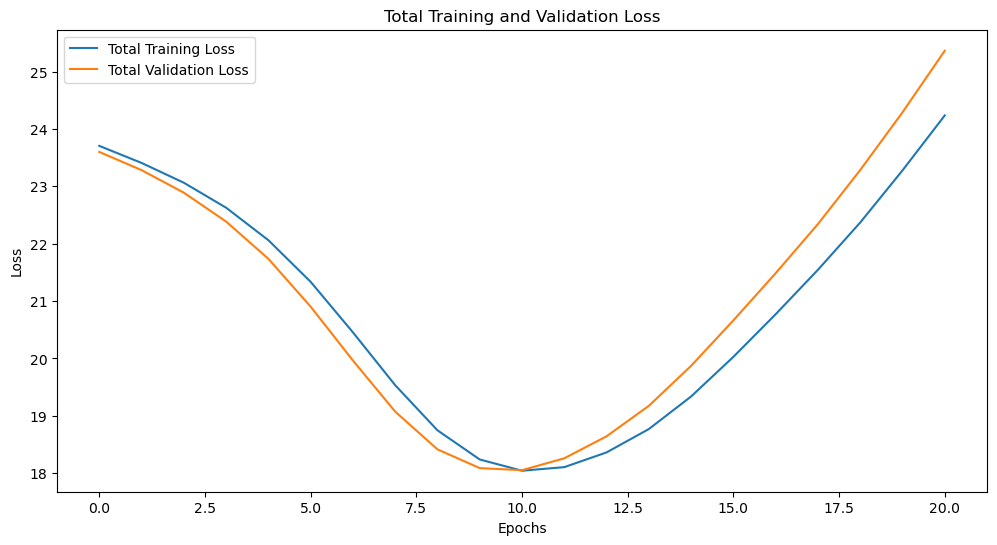

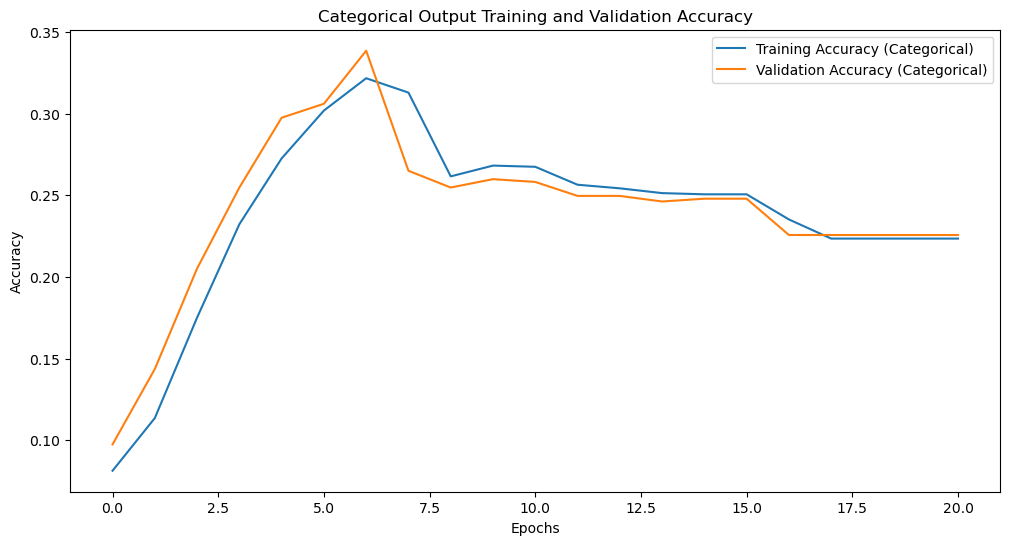

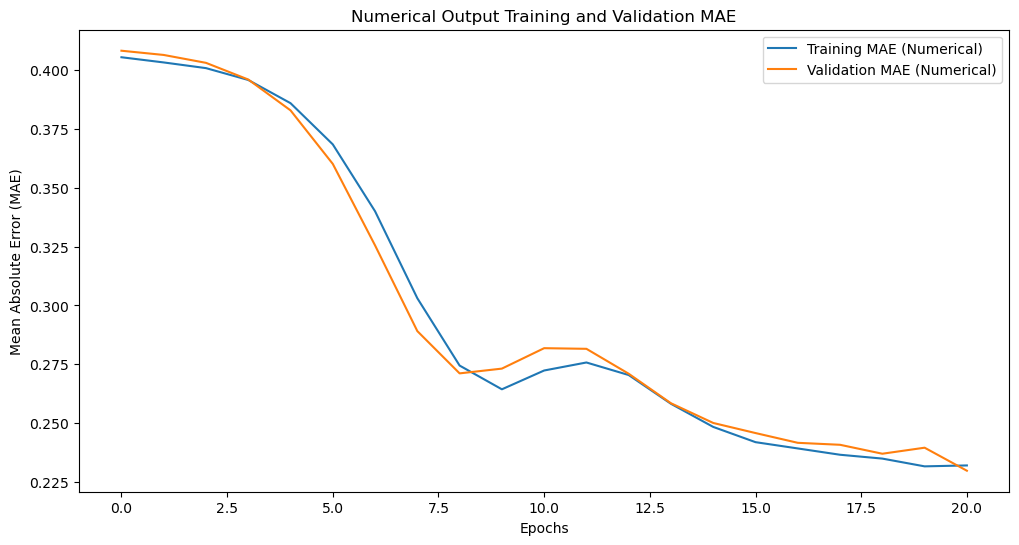

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation loss for both outputs
plt.figure(figsize=(12, 6))

# Loss for categorical and numerical outputs
plt.plot(history.history['loss'], label='Total Training Loss')
plt.plot(history.history['val_loss'], label='Total Validation Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Categorical Output Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['categorical_output_accuracy'], label='Training Accuracy (Categorical)')
plt.plot(history.history['val_categorical_output_accuracy'], label='Validation Accuracy (Categorical)')
plt.title('Categorical Output Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Numerical Output Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))
plt.plot(history.history['numerical_output_mae'], label='Training MAE (Numerical)')
plt.plot(history.history['val_numerical_output_mae'], label='Validation MAE (Numerical)')
plt.title('Numerical Output Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()


In [45]:
print(y_cat_train.shape)

(1950, 24)
